# EXPLORATION_14. 프로젝트 : 주식 예측에 도전해 보자
ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았다. 이제 실제 주식값 예측에 도전해 본다. 데이터는 과거의 일자별 시세이다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 본다. stock_prediction/data 에 올라와 있을 것이다.

**아래 명령어로 005930.KS.csv 파일이 존재하는지 확인해본다.**

In [3]:
! cd ~/aiffel/stock_prediction/data

In [4]:
! ls

Untitled1.ipynb  Untitled.ipynb


## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [5]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [7]:
# 로그 변환 시도 
ts_log = np.log(ts)
ts_logb

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

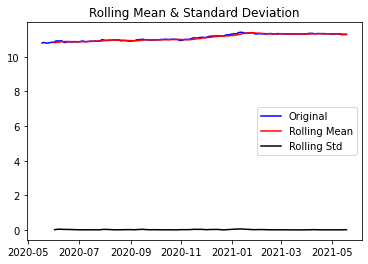

In [12]:
plot_rolling_statistics(ts_log, window=12)

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [14]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [15]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

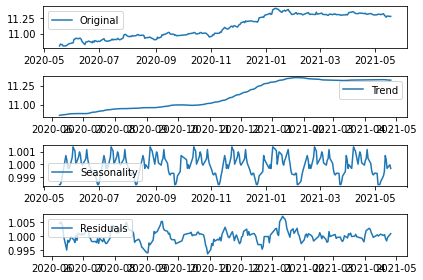

In [16]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

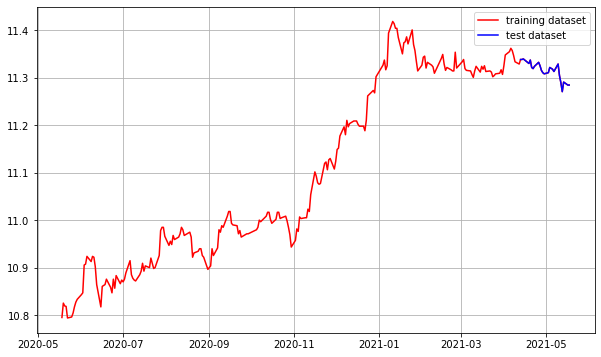

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [22]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


#### 4-1. AR(자기회귀, Autoregressive)
- 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
- AR은 시계열의 Residual에 해당하는 부분을 모델링한다고 볼 수 있다.
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점이라고 볼 수 있다. 

#### 4-2. MA(이동평균, Moving Average)
- MA는 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있다. 
- 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점이라고 볼 수 있다.

#### 4-3. I(차분누적, Integration)
- ARIMA는 위 3가지 모델을 모두 한꺼번에 고려한다. 주식값을 예측하는 우리의 태도와 비슷하지 않나?
- 오늘은 주식이 올라서 균형을 맞추겠지?'라는 AR 형태의 기대와
- '어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?'라는 MA 형태의 우려가
동시에 떠오르게 됩니다.
ARIMA는 두 모델 사이에서 적정 수준을 찾아가는 능력을 보여 준다.

#### 4-4 ARIMA 모델의 모수 p, q, d
RIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 한다. 핵심적인 숫자들을 잘 정해야 올바른 예측식을 구할 수 있다는 것이다.
ARIMA의 모수는 아래의 3가지가 있다. 
- p : 자기회귀 모형(AR)의 시차
- q : 이동평균 모형(MA)의 시차
- d : 차분누적(I) 횟수

이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻이다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문이다.
그러면 모수 p, q, d는 어떻게 결정될까? 여기서부터의 설명이 매우 어렵다.
ARIMA의 적절한 모수 p, d, q를 선택하는 방법으로 많은 통계학적인 시도들이 있지만 대표적인 것만 이야기하면 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)를 말할 수 있다. 이 AutoCorrelation은 우리가 맨 첫 스텝에서 다룬 개념 중 하나인 자기상관계수와 같은 것이다.

**ACF**
- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
- 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명함

**PACF**
- 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
- k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치

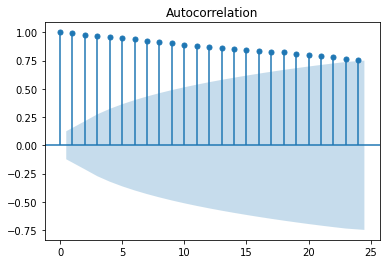

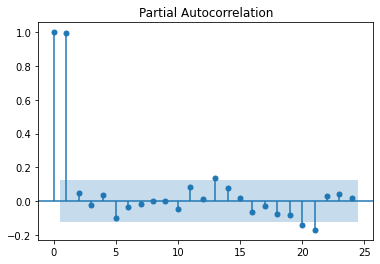

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음을 통계학적으로 설명하는 아티클에서 요약결론 부분만 가져온 것이다.
이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같다.  p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.  PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.
반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋다. 

**d를 구하기 위해서는 좀 다른 접근이 필요하다. d 차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야한다.**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


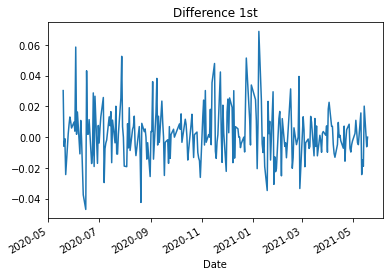

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


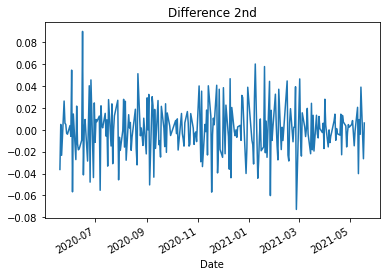

In [21]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 5 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 한다. ARIMA 모델을 훈련하는 것은 아래와 같이 간단하다. 

In [23]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 06 Sep 2021   AIC                          -1164.792
Time:                        16:41:26   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

**ARIMA 모델이 훈련 결과를 시각적으로 확인해 본다.**

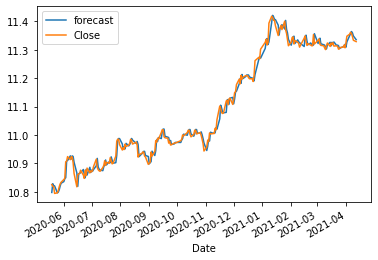

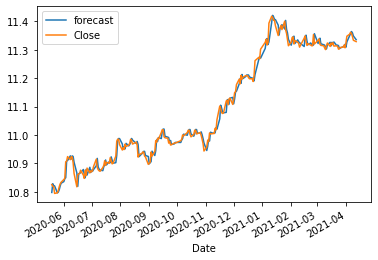

In [24]:
fitted_m.plot_predict()

**forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 본다**

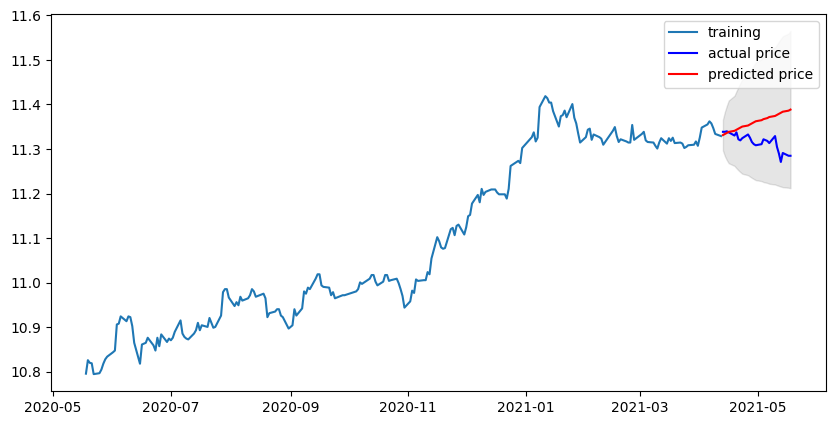

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다.
**np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다.**

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


## STEP 6 : 다른 주식 종목 예측해 보기

- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### 1. NAVER
#### 1.1 데이터 준비

In [27]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/naver.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    314500.0
2020-09-08    311000.0
2020-09-09    304500.0
2020-09-10    307500.0
2020-09-11    306000.0
Name: Close, dtype: float64

#### 1.2 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [28]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [29]:
# 로그 변환 시도 
ts_log = np.log(ts)
ts_log

Date
2020-09-07    12.658739
2020-09-08    12.647548
2020-09-09    12.626426
2020-09-10    12.636230
2020-09-11    12.631340
                ...    
2021-08-31    12.992255
2021-09-01    13.005830
2021-09-02    13.000196
2021-09-03    13.022543
2021-09-06    13.025852
Name: Close, Length: 248, dtype: float64

#### 1.3 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [31]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

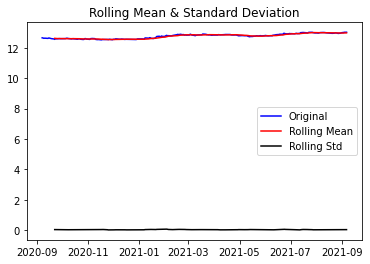

In [32]:
plot_rolling_statistics(ts_log, window=12)

In [33]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [34]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.350788
p-value                          0.917997
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [35]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

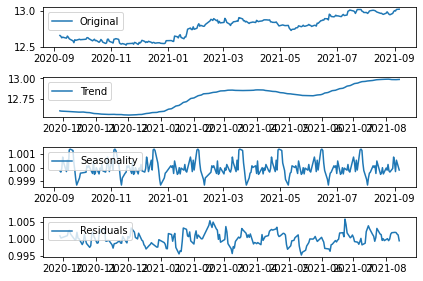

In [36]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.629220e+00
p-value                        5.771542e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


#### 1.4 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

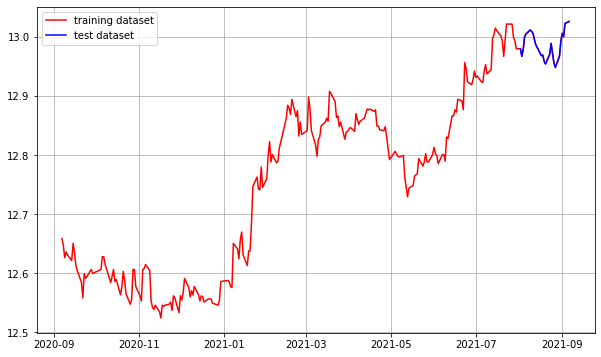

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [39]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-07    12.658739
2020-09-08    12.647548
Name: Close, dtype: float64
(223,)
(25,)


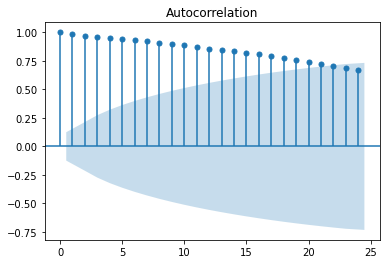

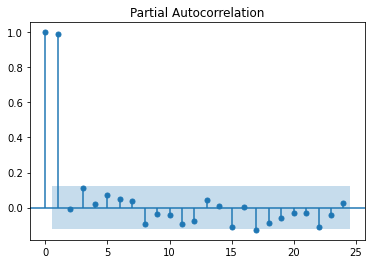

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.269325e+01
p-value                        1.120256e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


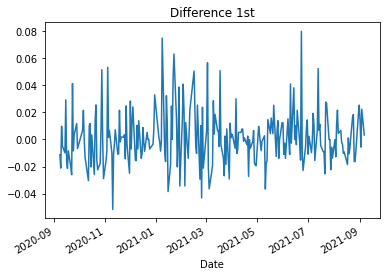

In [41]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.945369e+00
p-value                        1.000415e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


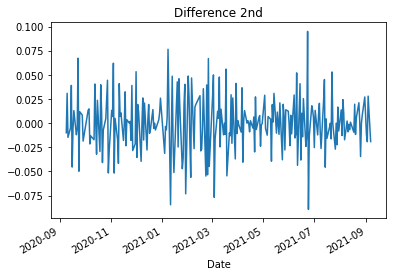

In [42]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 1.5 ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 한다. ARIMA 모델을 훈련하는 것은 아래와 같이 간단하다. 

In [43]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 545.646
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 07 Sep 2021   AIC                          -1085.292
Time:                        01:55:39   BIC                          -1075.084
Sample:                             1   HQIC                         -1081.170
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.072      0.284      -0.001       0.004
ar.L1.D.Close    -0.0285      0.067     -0.426      0.670      -0.160       0.103
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

**ARIMA 모델이 훈련 결과를 시각적으로 확인해 본다.**

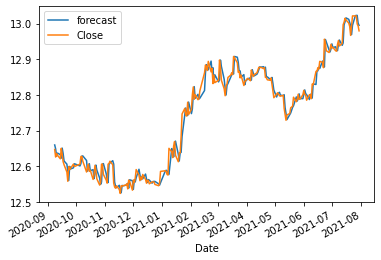

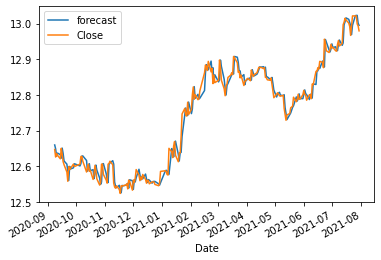

In [44]:
fitted_m.plot_predict()

**forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 본다.**

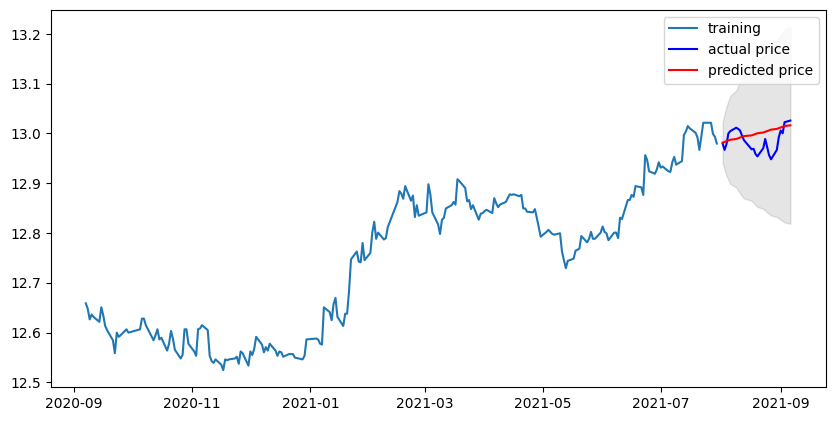

In [45]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

**np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다.**

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  136749736.94864967
MAE:  9598.722259287522
RMSE:  11694.004316257528
MAPE: 2.23%


### 2. Apple
#### 2.1 데이터 준비

In [47]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-08    112.820000
2020-09-09    117.320000
2020-09-10    113.489998
2020-09-11    112.000000
2020-09-14    115.360001
Name: Close, dtype: float64

#### 2.2 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [48]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [49]:
# 로그 변환 시도 
ts_log = np.log(ts)
ts_log

Date
2020-09-08    4.725794
2020-09-09    4.764905
2020-09-10    4.731715
2020-09-11    4.718499
2020-09-14    4.748058
                ...   
2021-08-30    5.031222
2021-08-31    5.022761
2021-09-01    5.027230
2021-09-02    5.034677
2021-09-03    5.038899
Name: Close, Length: 251, dtype: float64

#### 2.3 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [50]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

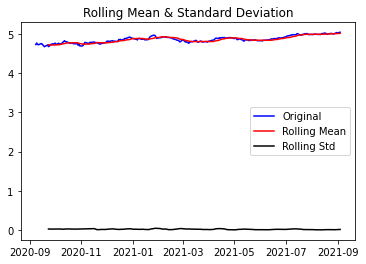

In [51]:
plot_rolling_statistics(ts_log, window=12)

In [52]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [53]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.964137
p-value                          0.766119
#Lags Used                       1.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [54]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

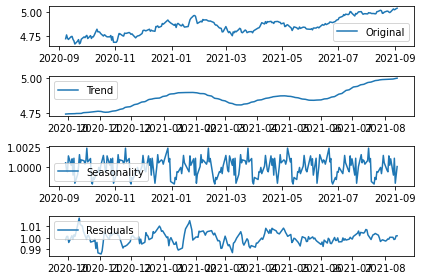

In [56]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [57]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.416770
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


#### 2.4 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

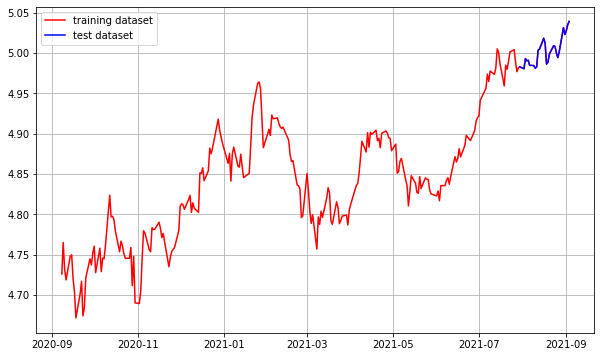

In [58]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [59]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-08    4.725794
2020-09-09    4.764905
Name: Close, dtype: float64
(225,)
(26,)


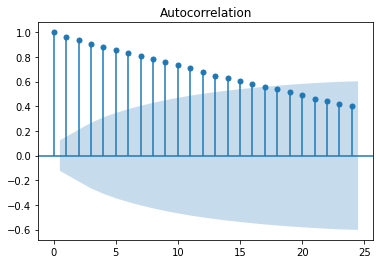

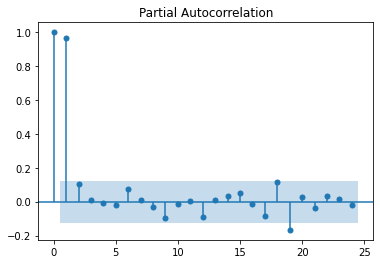

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.773999e+01
p-value                        3.405496e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


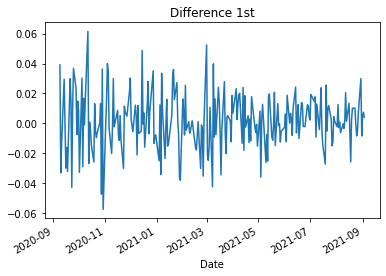

In [61]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.201193e+00
p-value                        2.363091e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


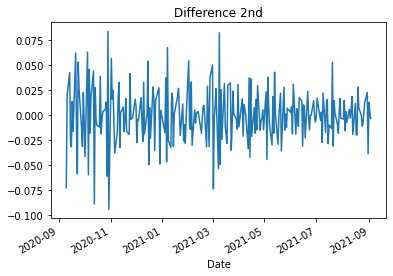

In [62]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 1.5 ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 한다. ARIMA 모델을 훈련하는 것은 아래와 같이 간단하다. 

In [63]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 569.835
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                          -1133.670
Time:                        02:13:43   BIC                          -1123.435
Sample:                             1   HQIC                         -1129.539
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      0.986      0.324      -0.001       0.003
ar.L1.D.Close    -0.1182      0.067     -1.769      0.077      -0.249       0.013
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

**ARIMA 모델이 훈련 결과를 시각적으로 확인해 본다.**

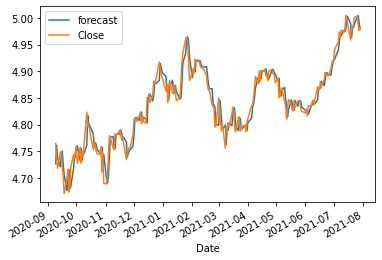

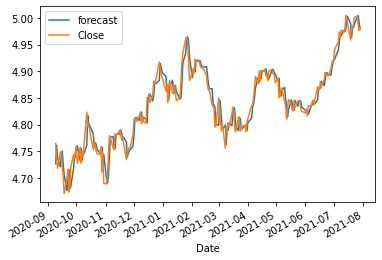

In [64]:
fitted_m.plot_predict()

**forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 본다.**

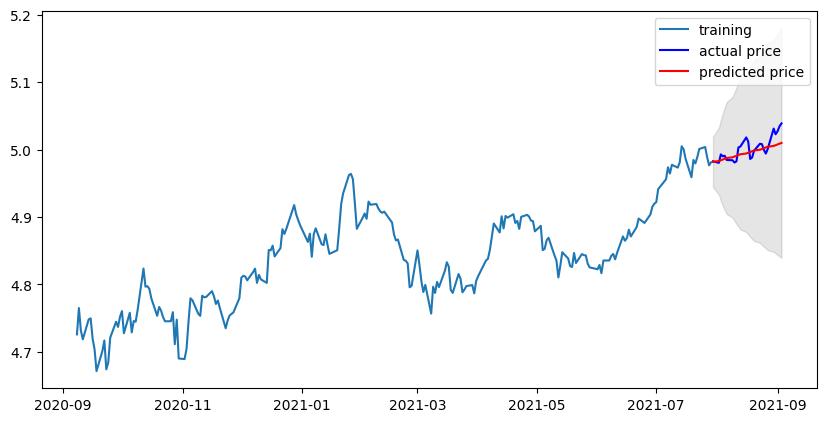

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

**np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다.**

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.034801430412081
MAE:  1.5856051803061735
RMSE:  2.0086815154254993
MAPE: 1.05%


### 3. NCSOFT
#### 3.1 데이터 준비

In [11]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/NC.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
nc = df['Close']

nc.head()

Date
2020-09-07    812000.0
2020-09-08    811000.0
2020-09-09    791000.0
2020-09-10    830000.0
2020-09-11    818000.0
Name: Close, dtype: float64

#### 3.2 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [12]:
# 결측치 처리
nc=nc.interpolate(method='time')
nc[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [13]:
# 로그 변환 시도 
nc_log = np.log(nc)
nc_log

Date
2020-09-07    13.607256
2020-09-08    13.606023
2020-09-09    13.581053
2020-09-10    13.629181
2020-09-11    13.614618
                ...    
2021-09-01    13.364525
2021-09-02    13.358226
2021-09-03    13.340695
2021-09-06    13.358226
2021-09-07    13.331002
Name: Close, Length: 249, dtype: float64

#### 3.3 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [14]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

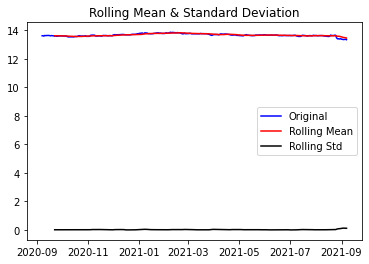

In [15]:
plot_rolling_statistics(nc_log, window=12)

In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(nc_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.624567
p-value                          0.865334
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [19]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(nc_log, model='multiplicative', period = 30)

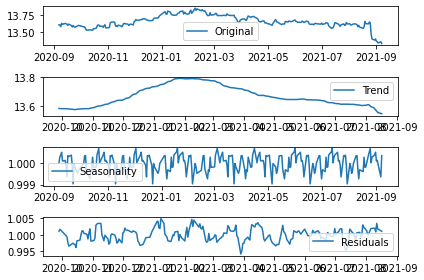

In [20]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [21]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.296925e+00
p-value                        3.487502e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


#### 3.4 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

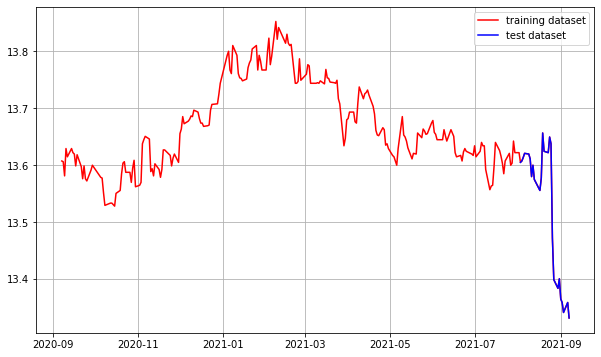

In [24]:
train_data, test_data = nc_log[:int(len(ts_log)*0.9)], nc_log[int(len(nc_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(nc_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [25]:
print(nc_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-09-07    13.607256
2020-09-08    13.606023
Name: Close, dtype: float64
(224,)
(25,)


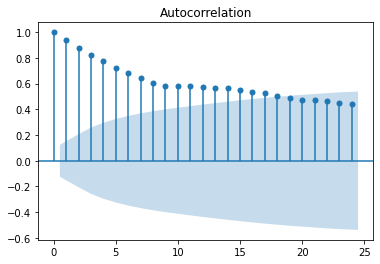

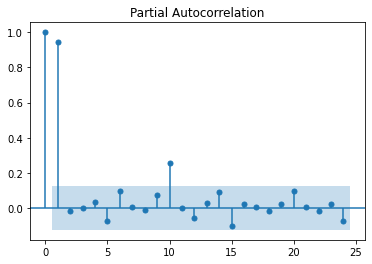

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(nc_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(nc_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.200091e+01
p-value                        3.348357e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


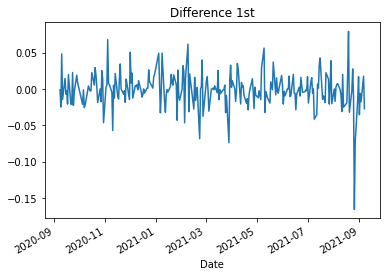

In [28]:
# 1차 차분 구하기
diff_1 = nc_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.472926e+00
p-value                        4.999597e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


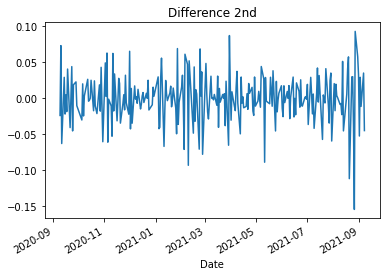

In [29]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 3.5 ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 한다. ARIMA 모델을 훈련하는 것은 아래와 같이 간단하다. 

In [38]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 547.013
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 07 Sep 2021   AIC                          -1088.025
Time:                        13:23:27   BIC                          -1077.804
Sample:                             1   HQIC                         -1083.899
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.617e-05      0.001      0.051      0.960      -0.002       0.003
ar.L1.D.Close    -0.0682      0.067     -1.024      0.306      -0.199       0.062
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

**ARIMA 모델이 훈련 결과를 시각적으로 확인해 본다.**

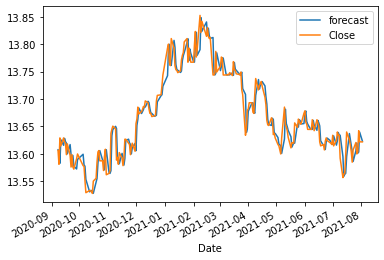

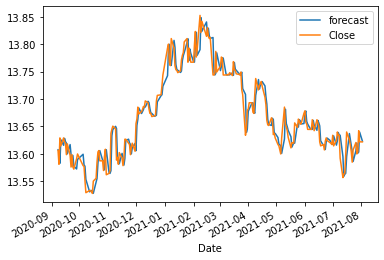

In [39]:
fitted_m.plot_predict()

**forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 본다.**

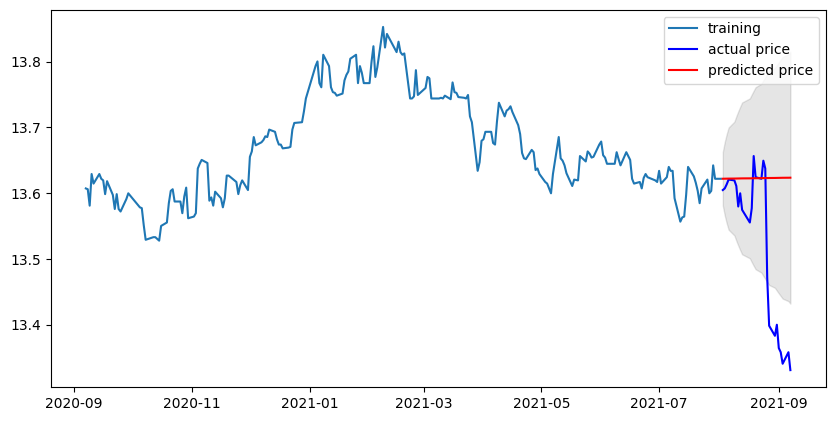

In [40]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

**np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다.**

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12114344911.588326
MAE:  76027.22079587729
RMSE:  110065.18482966503
MAPE: 11.48%


## 7. 회고 및 정리

- 네이버와 애플을 해보았을 때 그래프의 변화가 거의 없어서 뭐가 달라 진지 구별이 잘 되지 않았지만 엔씨소프트를 진행했을 때 다른 그래프를 볼 수 있었다. 
- 아직 차트와 수치를 보는 법에 대해서 이해가 덜 되다 보니 수치를 어떻게 변경해야 오차를 줄일 수 있는 지는 조금 더 공부를 해보아야 될거 같다. 
